In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from get_data import *
from dataloader import *
from test_function import *
from NN_classes import *
import logging
import os

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)

torch.Size([50, 2750, 3])
input_data size torch.Size([50, 2750, 3])


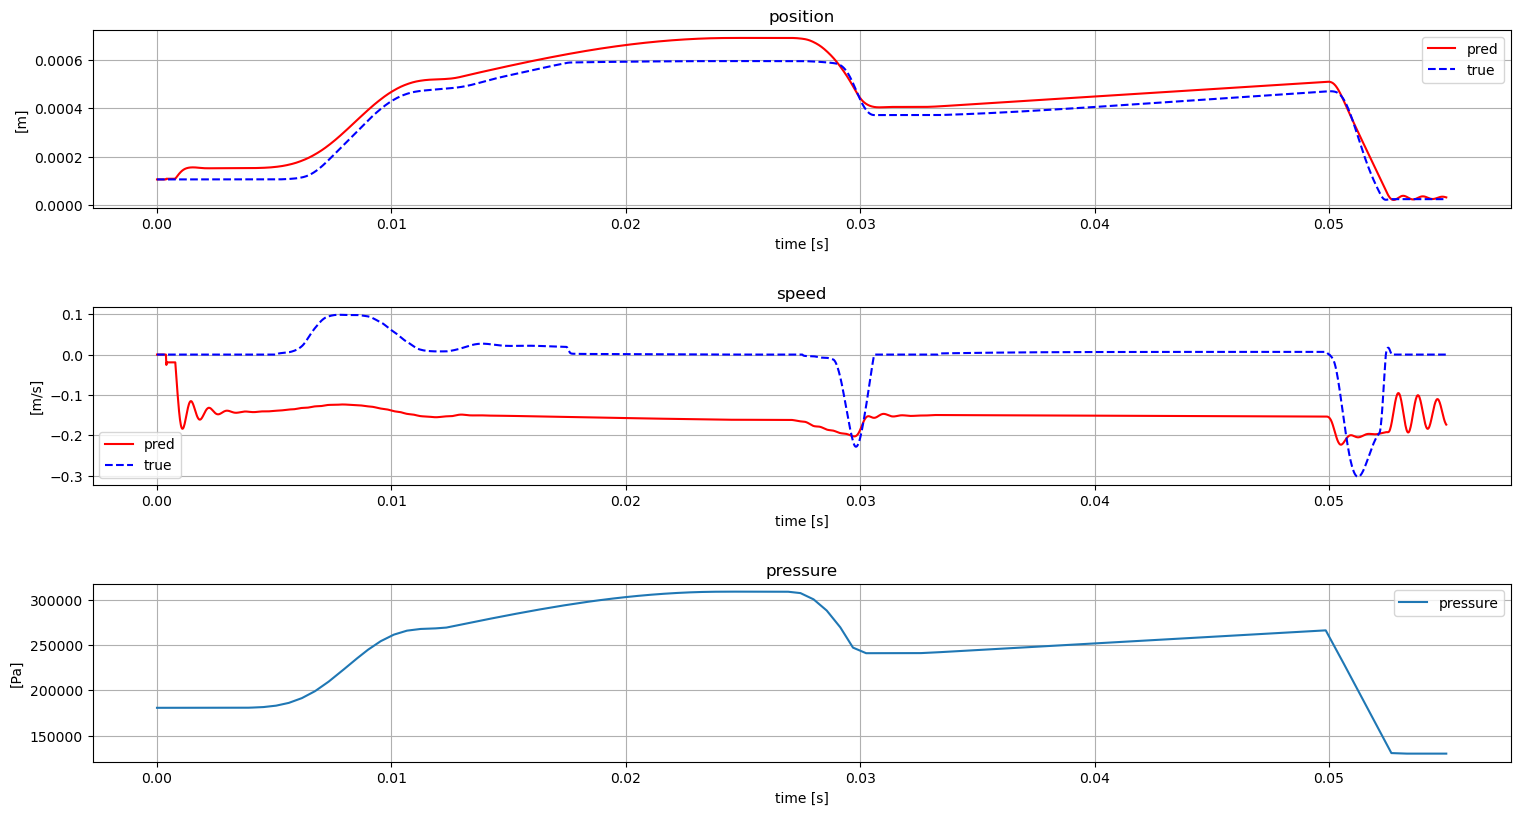

0.004847042371236001


In [25]:
# Save the model
# path = f"Ventil_trained_NNs\lstm_ws0.pth"
# #
# torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = r"Ventil_trained_NNs\or_tcn_0.pth"

params =                          {
                            "experiment_number" : 4,
                            "window_size" : 20,
                            "epochs" : 50,
                            "learning_rate" : 0.001,
                            "part_of_data" : 50, 
                            "percentage_of_data" : 0.7,
                            "batch_size" : 20,
                            "future" : 1,
                            "drop_half_timesteps" : True,
                            "cut_off_timesteps" : 200,

                            "input_channels" : 3,
                            "output" : 2,
                            "n_hidden" : 5,
                            "levels" : 4,
                            "kernel_size" : 7,
                            "dropout" : 0

                        }



input_data1, PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\save_data_test_5xlonger_dyndyn.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data3, PSW_max = get_data(path = "data\Testruns_from_trajectory_generator_t2_t6_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
                        

input_data = torch.cat((input_data1, input_data3))
input_data=input_data1[:,:,0:550-params["cut_off_timesteps"]]
input_data=input_data2

print(input_data.size())

np.random.seed(1234)
print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()

# Initialize the LSTM model

input_channels = params["input_channels"]
output = params["output"]
num_channels = [params["n_hidden"]] * params["levels"]
kernel_size = params["kernel_size"]
dropout = params["dropout"]

model = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params["window_size"])

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]
#%matplotlib qt 
#%matplotlib inline 

#test_loss, test_loss_deriv, total_loss, physloss
test_loss, test_loss_deriv, total_loss = test(test_data.to(device), model, model_type = "or_tcn", window_size=params["window_size"],
                                                         display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max, additional_data=None)
print(total_loss)
#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]